# Introduction
In this notebook, we provide examples and explanations about the usage of our implementation of the Lindblad equation proposed in [this paper](https://arxiv.org/abs/2402.06354). The main idea there is to find a transformation that turns the Bloch-Redfield equation (BRE) into a Lindblad master equation (LME), keeping the couplings that the secular approximation neglects and preserving the accuracy of the BRE. The main reason behind our efforts is to overcome the mathematical limitations of the BRE (it does not guarantee that the density matrix remains positive semidefinite at all times).

Our implementation should be compatible with recent versions of QuTiP (only tested with version 4.7.5), and uses it extensively. As such, it can be considered a modest extension of the package.

In [1]:
# file with our implementation
from src.lindbladAG import mesolveAG, old_brmesolve
# necessary qutip imports only
from qutip import Qobj, basis, brmesolve
# other useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# custom matplotlib style 
plt.style.use("style.mplstyle")

# Example 1: Comparison with qutip's brmesolve (no cross-correlations and no Lamb-shift)


## System's parameters
We first create a random system with a fixed number of levels (`nLevels`) and connected to a number of baths (`nOperators`). We build the Hamiltonian `H` and a list of operators coupling the system to the baths `a_ops`. All of these have to be Hermitian, just like the QuTiP's implementation of the BRE. Additionally, the system Hamiltonian does not need to be diagonal, but we restrict the size of the off-diagonal couplings to ensure that the timescale induced by the coupling to the environment is at least comparable to the timescale of the intrinsic couplings of the system, such that the former is not overshadowed by the latter. 

In [2]:
# size of system
nLevels = 4
nOperators = 2

# fix the seed for reproducibility
np.random.seed(12346789)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.05 + h.T*0.05 + np.diag(np.diagonal(h)))
evals = H.eigenenergies()

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    a_ops.append(Qobj(op))
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.61312539 0.01193694 0.07457166 0.05007917]
 [0.01193694 0.52063743 0.03848605 0.0514774 ]
 [0.07457166 0.03848605 0.65722849 0.04740586]
 [0.05007917 0.0514774  0.04740586 0.73006571]]

## Baths' parameters
Following the same approach as in [this paper](https://arxiv.org/abs/2402.06354), we generate a positive semidefinite, matrix valued function that takes energy as argument with the expression
\begin{equation*}
    \mathbf{J}(\hbar\omega) = \frac\hbar\pi \mathbf{g} \cdot \mathrm{Im}\left(\mathbf{h} - \omega\right)^{-1}\cdot \mathbf{g}.
\end{equation*}
We choose the parameters in $\mathbf{g}$ and $\mathbf{h}$ randomly, and thus generate physically consistent spectral density, $\mathbf{J}$, albeit one with off-diagonal terms. Since we don't want to treat bath cross-correlations in this first example, we simply remove the off-diagonal elements from $\mathrm{J}$ after creating it with the above expression.


In the code below, we create `J`, an array of SciPy interpolators that plays the role of spectral density. Even though our implementation can deal with cross-correlations, where a square array of interpolators is needed, we have included a simplified way to represent non-cross-correlated environments with a 1-dimensional array, as done below. In the next examples, we will show the usage of the more general approach.

In [3]:
# number of modes
nModes = 5

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)
# mode couplings
couplings = ((c:=np.random.rand(nModes, nModes)) + c.T - 2 * np.diag(np.diagonal(c))) * 0.5
# decay rate of each mode
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.0
# matrix 
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)
# mode "field strengths" as felt by each emitter operator
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# spectral density: create an array and interpolate it to obtain callable objects
# J_arr is a matrix J[w, i, j]
energy = np.linspace(-10, 10, 500)
J_arr = 1 / np.pi * g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
# J is an array of interpolators of J_arr.
# we remove the bath cross-correlations by keeping only the diagonal elements of J_arr and interpolating
J = np.empty(nOperators, dtype=object)
for i in range(nOperators):
    J[i] = interp1d(energy, J_arr[:, i, i], bounds_error=False, fill_value=0) 


Text(0, 0.5, '$\\hbar J_i$ (eV)')

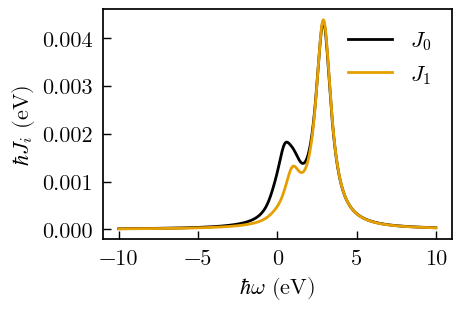

In [4]:
for i, j in enumerate(J):
    plt.plot(energy, j(energy), label=f"$J_{i}$")
plt.legend()
plt.xlabel("$\hbar\omega$ (eV)")
plt.ylabel("$\hbar J_i$ (eV)")

## Time evolution
Once the system and baths have been characterized, we solve the temporal evolution of the populations with QuTiP's `brmesolve` and our implementation of the method of [this paper](https://arxiv.org/abs/2402.06354). Our implementation is called with the function `mesolveAG`, in reference to the arithmetic and geometric means that are used to construct the Liouvillian. The main difference with respect to the `brmesolve` function call is how the spectral functions are passed. In `brmesolve`, the argument `a_ops` is a nested list of operators and their corresponding bath spectral function, whereas in `mesolveAG` we have separate arguments for the operators (`a_ops`) and bath functions (`J`). Additionally, in QuTiP's implementation of `brmesolve`, the spectral functions are related to the spectral density through $\mathbf{S} = 2\pi \mathbf{J}$. Since the `J` instance defined above is an array of interpolators, multiplication by scalars is not supported and the $2\pi$ factor is included in the operators `a_opsBR` below.

In [5]:
# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()
print(psi0)

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Bloch-Redfield
# the definition of the spectral functions in qutip is S = 2πJ. The 2π can be included in the operators with a square root.
a_opsBR = [[np.sqrt(2*np.pi)*a, j] for a, j in zip(a_ops, J)]
rhoBR = brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_opsBR, e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation
# comparable syntax. use_secular=False is the default option here.
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, e_ops=e_ops, use_secular=False).expect

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.596377  ]
 [0.60591381]
 [0.48486038]
 [0.20521535]]


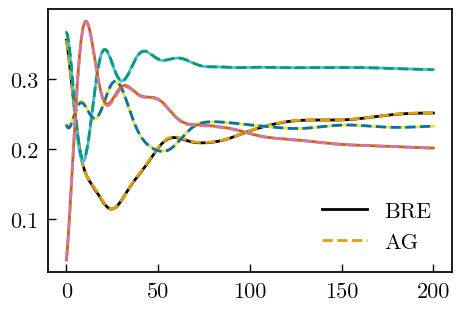

In [6]:
for i, (pBR, pAG) in enumerate(zip(rhoBR, rhoAG)):
    plt.plot(t, pBR.real, label="BRE"*(i==0))
    plt.plot(t, pAG.real, "--", label="AG"*(i==0))
plt.legend()

# Example 2: Lamb shift

implement lamb shift part for BR (old version)

In [20]:
# size of system
nLevels = 4
nOperators = 2

# fix the seed for reproducibility
np.random.seed(12346789)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.05 + h.T*0.05 + np.diag(np.diagonal(h)))
evals = H.eigenenergies()

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    a_ops.append(Qobj(op))
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.61312539 0.01193694 0.07457166 0.05007917]
 [0.01193694 0.52063743 0.03848605 0.0514774 ]
 [0.07457166 0.03848605 0.65722849 0.04740586]
 [0.05007917 0.0514774  0.04740586 0.73006571]]

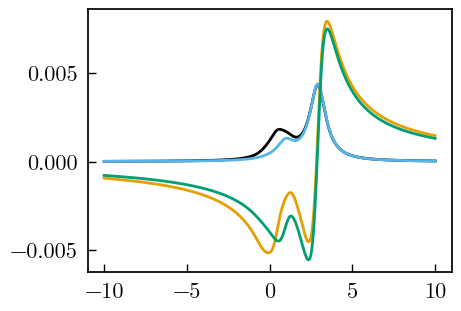

In [21]:
# number of modes
nModes = 5

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)
# mode couplings
couplings = ((c:=np.random.rand(nModes, nModes)) + c.T - 2 * np.diag(np.diagonal(c))) * 0.5
# decay rate of each mode
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.0
# matrix 
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)
# mode "field strengths" as felt by each emitter operator
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# spectral density: create an array and interpolate it to obtain callable objects
# J_arr is a matrix J[w, i, j]
energy = np.linspace(-10, 10, 500)
J_arr = 1 / np.pi * g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
L_arr = - g @ np.linalg.inv(h - energy[:, np.newaxis, np.newaxis] * np.identity(nModes)).real @ g.T
# J is an array of interpolators of J_arr.
# we remove the bath cross-correlations by keeping only the diagonal elements of J_arr and interpolating
J = np.empty(nOperators, dtype=object)
L = np.empty(nOperators, dtype=object)
Si2L = np.empty(nOperators, dtype=object)
for i in range(nOperators):
    J[i] = interp1d(energy, J_arr[:, i, i], bounds_error=False, fill_value=0) 
    L[i] = interp1d(energy, L_arr[:, i, i], bounds_error=False, fill_value=0) 
    Si2L[i] = interp1d(energy, 2*np.pi * J_arr[:, i, i] + 2j * L_arr[:, i, i], bounds_error=False, fill_value=0)
    plt.plot(energy, J[i](energy), label=f"$J_{i}$")
    plt.plot(energy, L[i](energy), label=f"$\Lambda_{i}$")
# plt.legend(ncols=2)
# plt.xlabel("$\hbar\omega$ (eV)")
# plt.ylabel("$\hbar J_i\ \mathrm{and}\ \hbar\Lambda_i$ (eV)")

In [22]:
# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()
print(psi0)

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Bloch-Redfield
# the definition of the spectral functions in qutip is S = 2πJ. The 2π can be included in the operators with a square root.
a_opsBR = [a for a in a_ops]
rhoBR_LS = old_brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_opsBR, spectra_cb=Si2L, e_ops=e_ops, use_secular=False).expect
# rhoBR = old_brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_opsBR, spectra_cb=J, e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation
# comparable syntax. use_secular=False is the default option here.
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, L=L, e_ops=e_ops, use_secular=False).expect

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.596377  ]
 [0.60591381]
 [0.48486038]
 [0.20521535]]


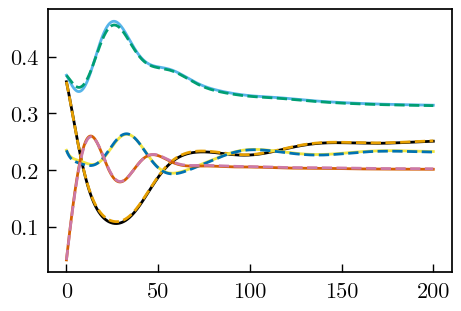

In [23]:
for pBRLS, pAG in zip(rhoBR_LS, rhoAG):
    plt.plot(t, pBRLS.real)
    plt.plot(t, pAG.real, "--")
    # plt.plot(t, pBR.real, ":")